# Predicting Pokemon Types from Images and Statistics

Scott Ratchford, (c) 2025

See `LICENSE.txt` for license information.

## Setup

### Constants and Parameters

In [68]:
# Set paths to data files and directories

import os
import pandas as pd
import numpy as np

CWD = os.getcwd()

# Input paths for data
POKEDEX_PATH = os.path.join(CWD, "data", "pokemon_images", "pokedex.csv")   # Modified .csv file from "Pokemon with Stats and Images"
PKMN_STATS_PATH = os.path.join(CWD, "data", "pokemon_stats.csv")            # .csv file from "Pokemon Pokedex"

# Output paths for created and modified data
PKMN_IMG_COLORS_PATH = os.path.join(CWD, "pokemon_colors.csv")              # Pokemon color data output

RNG_SEED = 151

### Import Datasets

In [69]:
from sklearn.preprocessing import LabelEncoder

# Import in-game statistics dataset
pkmn_stats = pd.read_csv(POKEDEX_PATH, encoding="utf-8", index_col=0)
size_before = pkmn_stats.shape[0]

# Drop ignored rows
pkmn_stats = pkmn_stats[pkmn_stats["Ignore"] == False]
print(f"Dropped {size_before - pkmn_stats.shape[0]} ignored Pokemon. See README.md for details.")

print(f"PKMN stats rows: {pkmn_stats.shape[0]}")
print(f"PKMN stats columns: {list(pkmn_stats.columns)}")

# Set Name to lowercase
pkmn_stats["Name"] = pkmn_stats["Name"].apply(lambda x: x.lower())

# Encode type strings (to ints)
type_label_encoder = LabelEncoder()
pkmn_stats["Type 1"] = type_label_encoder.fit_transform(pkmn_stats["Type 1"])
pkmn_stats["Type 1"] = pkmn_stats["Type 1"].astype(dtype=int)
pkmn_stats["Type 2"] = type_label_encoder.fit_transform(pkmn_stats["Type 2"])
pkmn_stats["Type 2"] = pkmn_stats["Type 2"].astype(dtype=int)

# Change NaN values to "None"
pkmn_stats["Type 2"] = pkmn_stats["Type 2"].apply(lambda x: x if pd.notna(x) else "None")

# Import image colors dataset
pkmn_color_df = pd.read_csv(PKMN_IMG_COLORS_PATH, encoding="utf-8", index_col=0).reset_index(drop=True)
pkmn_color_df = pkmn_color_df.sort_values(by="Number")
print(f"PKMN color rows: {pkmn_color_df.shape[0]}")
print(f"PKMN colors columns: {list(pkmn_color_df.columns)}")

# Add Number and Train columns to pkmn_stats
pkmn_stats = pd.merge(pkmn_stats, pkmn_color_df[["Name", "Number", "Train"]], on=["Name", ], how="inner")

Dropped 232 ignored Pokemon. See README.md for details.
PKMN stats rows: 983
PKMN stats columns: ['Name', 'Type 1', 'Type 2', 'Total', 'HP', 'Attack', 'Defense', 'SP. Atk.', 'SP. Def', 'Speed', 'Ignore', 'Filename']
PKMN color rows: 959
PKMN colors columns: ['Name', 'Type 1', 'Type 2', 'Filename', 'Number', 'Train', 'black', 'blue', 'pink', 'green', 'purple', 'red', 'white', 'yellow', 'orange']


In [70]:
# Split in-game statistics into training and testing
from sklearn.preprocessing import LabelEncoder

# Drop columns that provide too much or unneeded information about the Pokemon
drop_stats_cols = ["Name", "Ignore", "Filename", "Number", "Train", ]

pkmn_stats_train = pkmn_stats[pkmn_stats["Train"] == True]
pkmn_stats_test = pkmn_stats[pkmn_stats["Train"] == False]

X_stats_train = pkmn_stats_train.drop(labels=(drop_stats_cols + ["Type 1", "Type 2", ]), axis=1).copy()
X_stats_test = pkmn_stats_test.drop(labels=(drop_stats_cols + ["Type 1", "Type 2", ]), axis=1).copy()
y_stats_train = pkmn_stats_train[["Type 1", "Type 2", ]].copy()
y_stats_test = pkmn_stats_test[["Type 1", "Type 2", ]].copy()

print(f"Split Pokemon statistics into {X_stats_train.shape[0]} training and {X_stats_test.shape[0]} testing.")

Split Pokemon statistics into 767 training and 192 testing.


In [71]:
# Split image colors into training and testing
from sklearn.preprocessing import StandardScaler

pkmn_color_train_df = pkmn_color_df[pkmn_color_df["Train"] == True]
pkmn_color_test_df = pkmn_color_df[pkmn_color_df["Train"] == False]

print(f"Color data for {pkmn_color_train_df.shape[0]} testing Pokemon loaded.")
print(f"Color data for {pkmn_color_test_df.shape[0]} testing Pokemon loaded.")

drop_color_cols = []
# Drop columns that provide too much information about the Pokemon
drop_color_cols.extend(["Name", "Number", "Filename", ])
# Drop other columns
drop_color_cols.extend(["Train", ])
# Drop columns containing target information
drop_color_cols.extend(["Type 1", "Type 2", ])

X_colors_train = pkmn_color_train_df.drop(labels=drop_color_cols, axis=1).copy()
X_colors_test = pkmn_color_test_df.drop(labels=drop_color_cols, axis=1).copy()
y_colors_train = pkmn_color_train_df[["Type 1", "Type 2", ]].copy()
y_colors_test = pkmn_color_test_df[["Type 1", "Type 2", ]].copy()

# Change NaN values to "None"
y_colors_train["Type 2"] = y_colors_train["Type 2"].apply(lambda x: x if pd.notna(x) else "None")
y_colors_test["Type 2"] = y_colors_test["Type 2"].apply(lambda x: x if pd.notna(x) else "None")

# Scale color data
color_cols = [
    'black', 'blue', 'pink', 'green', 'purple', 'red', 'white', 'yellow', 'orange',
]
scaler = StandardScaler()
X_colors_train[color_cols] = scaler.fit_transform(X_colors_train[color_cols])
X_colors_test[color_cols] = scaler.fit_transform(X_colors_test[color_cols])

Color data for 767 testing Pokemon loaded.
Color data for 192 testing Pokemon loaded.


### Helper Functions

In [72]:
def either_correct(pred: tuple[str, str], true: tuple[str, str]) -> bool:
    for p in pred:
        if p == "None":
            continue
        if p in true:
            return True
    
    return False

def both_correct(pred: tuple[str, str], true: tuple[str, str]) -> bool:
    if len(pred) != 2 or len(true) != 2:
        raise ValueError("Length of pred and true must each be 2.")
    pred_set = set(pred)
    if "None" in pred:
        pred_set.remove("None")
        
    return pred_set.intersection(set(true)) == set(pred)

def get_either_correct(pred: pd.DataFrame, true: pd.DataFrame) -> pd.DataFrame:
    df = pd.merge(pred, true, how="left", left_index=True, right_index=True)
    df["either"] = df.apply(lambda x: either_correct((x["Type 1"], x["Type 2"]), (x["Type 1 Pred"], x["Type 2 Pred"])), axis=1)

    return df

def get_both_correct(pred: pd.DataFrame, true: pd.DataFrame) -> pd.DataFrame:
    df = pd.merge(pred, true, how="left", left_index=True, right_index=True)
    df["both"] = df.apply(lambda x: both_correct((x["Type 1"], x["Type 2"]), (x["Type 1 Pred"], x["Type 2 Pred"])), axis=1)

    return df

def either_accuracy_score(pred: pd.DataFrame, true: pd.DataFrame) -> float:
    return get_either_correct(pred, true)["either"].mean()

def both_accuracy_score(pred: pd.DataFrame, true: pd.DataFrame) -> float:
    return get_both_correct(pred, true)["both"].mean()

## Multi-Label Type Classification Based on In-Game Statistics

These models use in-game statistics to predict the values of `Type 1` and `Type 2`.

### K-Nearest Neighbors

In [6]:
# Create the KNN model for in-game statistics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputClassifier

# hyperparameters to try
knn_stats_hyperparameters = [
    {
        "estimator__n_neighbors": range(3, 11),
        "estimator__leaf_size": range(10, 41),
        "estimator__p": range(1, 4),
        "estimator__weights": ("distance", "uniform", ),
        "estimator__algorithm": ("kd_tree", "ball_tree", ),
    },
]

knn_stats_search = GridSearchCV(
    estimator=MultiOutputClassifier(KNeighborsClassifier()),
    param_grid=knn_stats_hyperparameters,
    cv = 5
)
knn_stats_model = knn_stats_search.fit(X_stats_train, y_stats_train)

print(knn_stats_model.best_params_)

{'estimator__algorithm': 'kd_tree', 'estimator__leaf_size': 39, 'estimator__n_neighbors': 10, 'estimator__p': 1, 'estimator__weights': 'distance'}


In [7]:
knn_stats_pred = pd.DataFrame(knn_stats_model.predict(X_stats_test), columns=["Type 1 Pred", "Type 2 Pred"])

acc_either = either_accuracy_score(knn_stats_pred, y_stats_test)
acc_both = both_accuracy_score(knn_stats_pred, y_stats_test)

print(f"Either type accuracy: {acc_either}")
print(f"Both type accuracy: {acc_both}")

Either type accuracy: 0.09895833333333333
Both type accuracy: 0.010416666666666666


### Decision Tree

In [8]:
# Create the DT model for in-game statistics
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputClassifier

# hyperparameters to try
dt_stats_hyperparameters = [
    {
        "estimator__criterion": ("gini", "entropy", "log_loss"),
        "estimator__max_depth": range(6, 22, 2),
        "estimator__min_samples_split": range(2, 12, 2),
        "estimator__min_samples_leaf": range(2, 20, 2),
        "estimator__random_state": (RNG_SEED, ),
    },
]

dt_stats_search = GridSearchCV(
    estimator=MultiOutputClassifier(DecisionTreeClassifier()),
    param_grid=dt_stats_hyperparameters,
    cv = 5
)
dt_stats_model = dt_stats_search.fit(X_stats_train, y_stats_train)

print(dt_stats_model.best_params_)

{'estimator__criterion': 'gini', 'estimator__max_depth': 10, 'estimator__min_samples_leaf': 14, 'estimator__min_samples_split': 2, 'estimator__random_state': 151}


In [9]:
dt_stats_pred = pd.DataFrame(dt_stats_model.predict(X_stats_test), columns=["Type 1 Pred", "Type 2 Pred"])

acc_either = either_accuracy_score(dt_stats_pred, y_stats_test)
acc_both = both_accuracy_score(dt_stats_pred, y_stats_test)

print(f"Either type accuracy: {acc_either}")
print(f"Both type accuracy: {acc_both}")

Either type accuracy: 0.08333333333333333
Both type accuracy: 0.010416666666666666


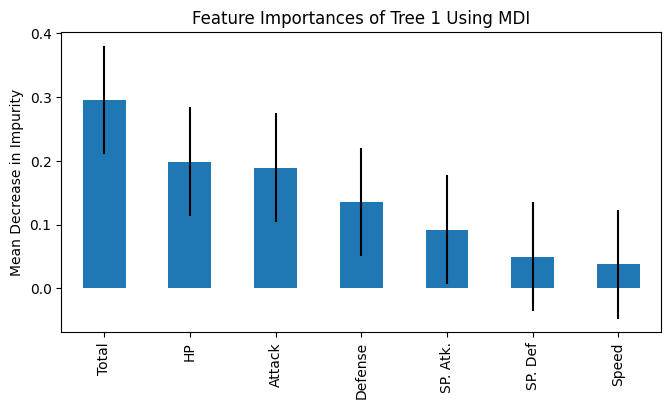

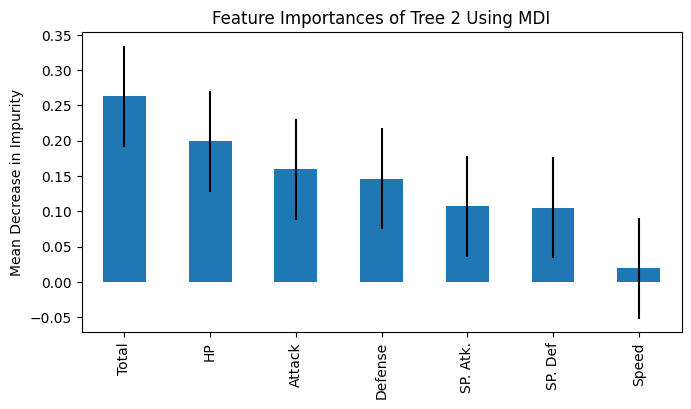

In [10]:
# Extract most important features
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

for i, tree in enumerate(dt_stats_model.best_estimator_.estimators_):
    std = np.std(tree.feature_importances_, axis=0)

    feature_names = X_stats_train.columns.tolist()
    feature_importances = pd.Series(sorted(tree.feature_importances_, reverse=True), index=feature_names)

    fig = plt.figure(figsize=(6, 3))
    axes = fig.add_axes(rect=(0, 0, 1, 1))

    feature_importances.plot.bar(yerr=std, ax=axes)
    axes.set_title(f"Feature Importances of Tree {i+1} Using MDI")
    axes.set_ylabel("Mean Decrease in Impurity")

    plt.show()

## Multi-Label Type Classification Based on Image Colors

### Decision Tree

In [11]:
# Create the DT model for image colors
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputClassifier

# hyperparameters to try
dt_colors_hyperparameters = [
    {
        "estimator__criterion": ("gini", "entropy", "log_loss"),
        "estimator__max_depth": range(6, 14, 2),
        "estimator__min_samples_split": range(2, 12, 2),
        "estimator__min_samples_leaf": range(2, 20, 2),
        "estimator__random_state": (RNG_SEED, ),
    },
]

dt_colors_search = GridSearchCV(
    estimator=MultiOutputClassifier(DecisionTreeClassifier()),
    param_grid=dt_colors_hyperparameters,
    cv = 5
)
dt_colors_model = dt_colors_search.fit(X_colors_train, y_colors_train)

print(dt_colors_model.best_params_)

{'estimator__criterion': 'gini', 'estimator__max_depth': 8, 'estimator__min_samples_leaf': 18, 'estimator__min_samples_split': 2, 'estimator__random_state': 151}


In [12]:
dt_colors_pred = pd.DataFrame(dt_colors_model.predict(X_colors_test), columns=["Type 1 Pred", "Type 2 Pred"])

acc_either = either_accuracy_score(dt_colors_pred, y_colors_test)
acc_both = both_accuracy_score(dt_colors_pred, y_colors_test)

print(f"Either type accuracy: {acc_either}")
print(f"Both type accuracy: {acc_both}")

Either type accuracy: 0.125
Both type accuracy: 0.0


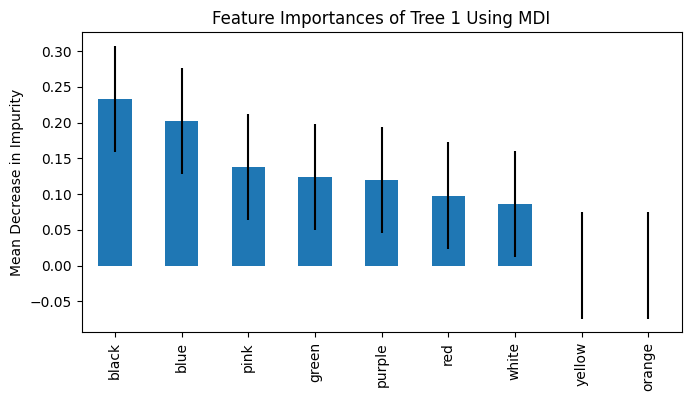

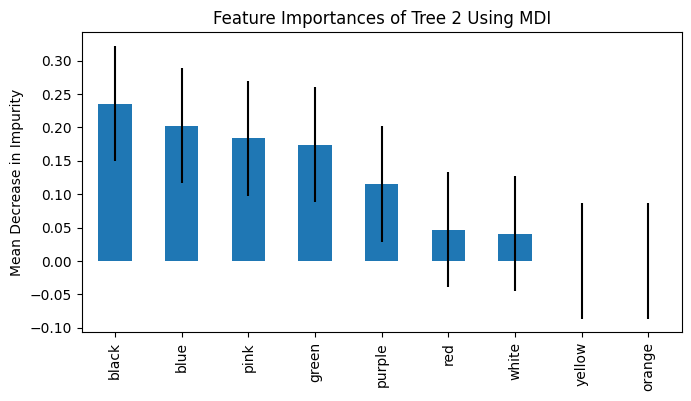

In [13]:
# Extract most important features
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

for i, tree in enumerate(dt_colors_model.best_estimator_.estimators_):
    std = np.std(tree.feature_importances_, axis=0)

    feature_names = X_colors_train.columns.tolist()
    feature_importances = pd.Series(sorted(tree.feature_importances_, reverse=True), index=feature_names)

    fig = plt.figure(figsize=(6, 3))
    axes = fig.add_axes(rect=(0, 0, 1, 1))

    feature_importances.plot.bar(yerr=std, ax=axes)
    axes.set_title(f"Feature Importances of Tree {i+1} Using MDI")
    axes.set_ylabel("Mean Decrease in Impurity")

    plt.show()

### Random Forest

In [14]:
# Create the RF model for image colors
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputClassifier

# hyperparameters to try
rf_colors_hyperparameters = [
    {
        "estimator__criterion": ['gini', ],    # 'entropy', 'log_loss'
        "estimator__n_estimators": range(100, 500, 100),
        "estimator__min_samples_split": range(2, 8, 2),
        "estimator__max_depth": list(range(10, 25, 5)) + [None, ],
        "estimator__class_weight": ["balanced", "balanced_subsample", ],
        "estimator__random_state": (RNG_SEED, ),
    },
]

rf_colors_search = GridSearchCV(
    estimator=MultiOutputClassifier(RandomForestClassifier()),
    param_grid=rf_colors_hyperparameters,
    cv = 5
)
rf_colors_model = rf_colors_search.fit(X_colors_train, y_colors_train)

print(rf_colors_model.best_params_)

{'estimator__class_weight': 'balanced_subsample', 'estimator__criterion': 'gini', 'estimator__max_depth': None, 'estimator__min_samples_split': 2, 'estimator__n_estimators': 400, 'estimator__random_state': 151}


In [15]:
rf_colors_pred = pd.DataFrame(rf_colors_model.predict(X_colors_test), columns=["Type 1 Pred", "Type 2 Pred"])

acc_either = either_accuracy_score(rf_colors_pred, y_colors_test)
acc_both = both_accuracy_score(rf_colors_pred, y_colors_test)

print(f"Either type accuracy: {acc_either}")
print(f"Both type accuracy: {acc_both}")

Either type accuracy: 0.078125
Both type accuracy: 0.0


### Multi-Layer Perceptron Neural Network

In [16]:
# Create the MLP model for image colors
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputClassifier

# hyperparameters to try
mlp_colors_hyperparameters = [
    {
        "estimator__activation": ('relu', ),
        "estimator__solver": ('adam', ),
        "estimator__learning_rate": ('constant', 'invscaling', ),
        "estimator__max_iter": range(4000, 4500, 500),
        "estimator__n_iter_no_change": range(4, 12, 2),
        "estimator__random_state": (RNG_SEED, ),
    },
]

mlp_colors_search = GridSearchCV(
    estimator=MultiOutputClassifier(MLPClassifier()),
    param_grid=mlp_colors_hyperparameters,
    cv = 5
)
mlp_colors_model = mlp_colors_search.fit(X_colors_train, y_colors_train)

print(mlp_colors_model.best_params_)

{'estimator__activation': 'relu', 'estimator__learning_rate': 'constant', 'estimator__max_iter': 4000, 'estimator__n_iter_no_change': 8, 'estimator__random_state': 151, 'estimator__solver': 'adam'}


In [17]:
mlp_colors_pred = pd.DataFrame(mlp_colors_model.predict(X_colors_test), columns=["Type 1 Pred", "Type 2 Pred"])

acc_either = either_accuracy_score(mlp_colors_pred, y_colors_test)
acc_both = both_accuracy_score(mlp_colors_pred, y_colors_test)

print(f"Either type accuracy: {acc_either}")
print(f"Both type accuracy: {acc_both}")

Either type accuracy: 0.09895833333333333
Both type accuracy: 0.0


## Clustering Pokemon by Image Color

### K-Means

In [73]:
# Use n_clusters=8
from sklearn.cluster import KMeans

km_colors_model = KMeans(
    n_clusters=8,
    random_state=RNG_SEED,
)
km_colors_model = km_colors_model.fit(X_colors_train)

### K-Means Clustering Analysis

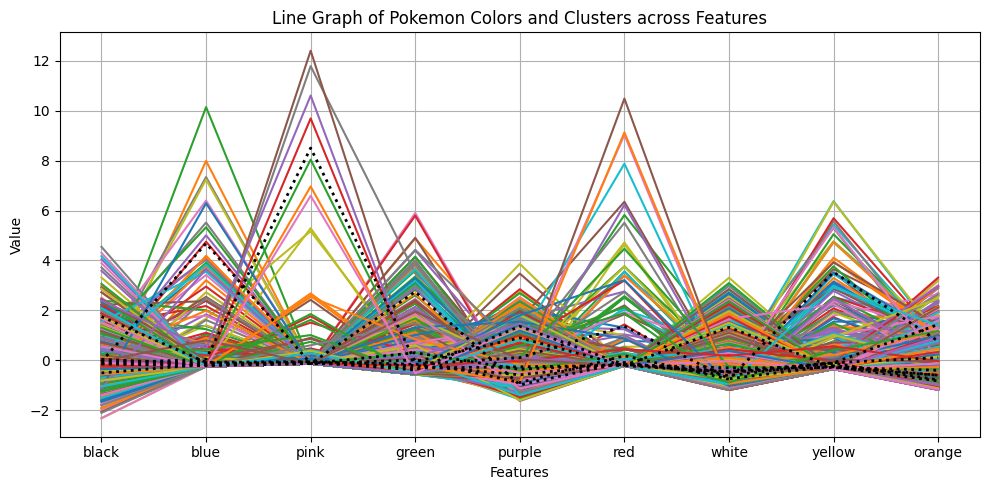

In [74]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

plt.figure(figsize=(10, 5))
for idx in X_colors_train.index:
    plt.plot(X_colors_train.columns, X_colors_train.loc[idx], label=f"Row {idx}")

for center in km_colors_model.cluster_centers_:
    plt.plot(X_colors_train.columns, center, color="black", linestyle="dotted", linewidth=2)

plt.title("Line Graph of Pokemon Colors and Clusters across Features")
plt.xlabel("Features")
plt.ylabel("Value")
plt.grid(True)
plt.tight_layout()
plt.show()

### Identify Color Clusters

In [75]:
km_colors_model = km_colors_model.fit(X_colors_train)
km_clusters_train = pd.DataFrame(km_colors_model.predict(X_colors_train), columns=["Cluster", ])
km_clusters_test = pd.DataFrame(km_colors_model.predict(X_colors_test), columns=["Cluster", ])

X_clusters_train = km_clusters_train.reset_index(drop=True)
X_clusters_test = km_clusters_test.reset_index(drop=True)
y_clusters_train = y_stats_train.reset_index(drop=True)
y_clusters_test = y_stats_test.reset_index(drop=True)

### Augment Stats with Cluster Data

In [76]:
X_clusters_stats_train = pd.merge(X_stats_train.reset_index(drop=True), X_clusters_train.reset_index(drop=True), how="inner", left_index=True, right_index=True)
X_clusters_stats_test = pd.merge(X_stats_test.reset_index(drop=True), X_clusters_test.reset_index(drop=True), how="inner", left_index=True, right_index=True)
y_clusters_stats_train = y_colors_train.reset_index(drop=True)
y_clusters_stats_test = y_colors_test.reset_index(drop=True)

### Augment Colors with Cluster Data

In [77]:
X_clusters_colors_train = pd.merge(X_colors_train.reset_index(drop=True), X_clusters_train.reset_index(drop=True), how="inner", left_index=True, right_index=True)
X_clusters_colors_test = pd.merge(X_colors_test.reset_index(drop=True), X_clusters_test.reset_index(drop=True), how="inner", left_index=True, right_index=True)
y_clusters_colors_train = y_colors_train.reset_index(drop=True)
y_clusters_colors_test = y_colors_test.reset_index(drop=True)

### Augment In-Game Statistics with Colors

In [78]:
X_stats_colors_train = pd.merge(X_colors_train.reset_index(drop=True), X_stats_train.reset_index(drop=True), how="inner", left_index=True, right_index=True)
X_stats_colors_test = pd.merge(X_colors_test.reset_index(drop=True), X_stats_test.reset_index(drop=True), how="inner", left_index=True, right_index=True)
y_stats_colors_train = y_colors_train.reset_index(drop=True)
y_stats_colors_test = y_colors_test.reset_index(drop=True)

### Decision Tree with Color Clusters Only

In [79]:
# Create the DT model for clusters and colors
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputClassifier

# hyperparameters to try
dt_clusters_hyperparameters = [
    {
        "estimator__criterion": ("gini", "entropy", "log_loss"),
        "estimator__max_depth": range(6, 22, 2),
        "estimator__min_samples_split": range(2, 12, 2),
        "estimator__min_samples_leaf": range(2, 20, 2),
        "estimator__random_state": (RNG_SEED, ),
    },
]

dt_clusters_search = GridSearchCV(
    estimator=MultiOutputClassifier(DecisionTreeClassifier()),
    param_grid=dt_clusters_hyperparameters,
    cv = 5
)
dt_clusters_model = dt_clusters_search.fit(X_clusters_train, y_clusters_train)

print(dt_clusters_model.best_params_)

{'estimator__criterion': 'gini', 'estimator__max_depth': 6, 'estimator__min_samples_leaf': 2, 'estimator__min_samples_split': 2, 'estimator__random_state': 151}


In [80]:
dt_clusters_pred = pd.DataFrame(dt_clusters_model.predict(X_clusters_test), columns=["Type 1 Pred", "Type 2 Pred"])

acc_either = either_accuracy_score(dt_clusters_pred, y_clusters_test)
acc_both = both_accuracy_score(dt_clusters_pred, y_clusters_test)

print(f"Either type accuracy: {acc_either}")
print(f"Both type accuracy: {acc_both}")

Either type accuracy: 0.5364583333333334
Both type accuracy: 0.08854166666666667


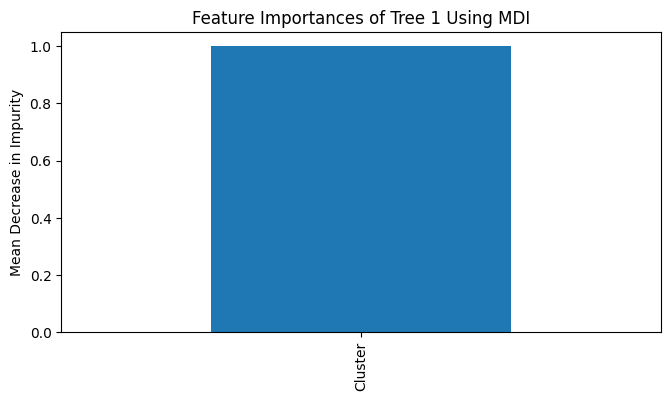

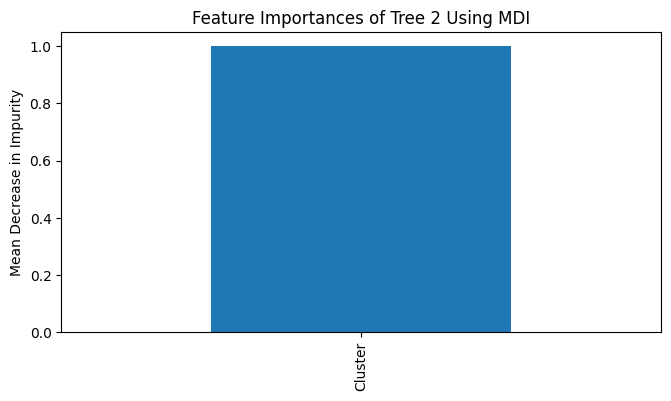

In [82]:
# Extract most important features
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

for i, tree in enumerate(dt_clusters_model.best_estimator_.estimators_):
    std = np.std(tree.feature_importances_, axis=0)

    feature_names = X_clusters_train.columns.tolist()
    feature_importances = pd.Series(sorted(tree.feature_importances_, reverse=True), index=feature_names)

    fig = plt.figure(figsize=(6, 3))
    axes = fig.add_axes(rect=(0, 0, 1, 1))

    feature_importances.plot.bar(yerr=std, ax=axes)
    axes.set_title(f"Feature Importances of Tree {i+1} Using MDI")
    axes.set_ylabel("Mean Decrease in Impurity")

    plt.show()

### Decision Tree with Color Clusters and Stats

In [83]:
# Create the DT model for clusters and colors
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputClassifier

# hyperparameters to try
dt_clusters_stats_hyperparameters = [
    {
        "estimator__criterion": ("gini", "entropy", "log_loss"),
        "estimator__max_depth": (10, 15, 20, None, ),
        "estimator__min_samples_split": (2, 6, 10, ),
        "estimator__min_samples_leaf":  range(1, 11),
        "estimator__random_state": (RNG_SEED, ),
    },
]

dt_clusters_stats_search = GridSearchCV(
    estimator=MultiOutputClassifier(DecisionTreeClassifier()),
    param_grid=dt_clusters_stats_hyperparameters,
    cv = 5
)
dt_clusters_stats_model = dt_clusters_stats_search.fit(X_clusters_stats_train, y_clusters_stats_train)

print(dt_clusters_stats_model.best_params_)

{'estimator__criterion': 'entropy', 'estimator__max_depth': 10, 'estimator__min_samples_leaf': 10, 'estimator__min_samples_split': 2, 'estimator__random_state': 151}


In [84]:
dt_clusters_stats_pred = pd.DataFrame(dt_clusters_stats_model.predict(X_clusters_stats_test), columns=["Type 1 Pred", "Type 2 Pred"])

acc_either = either_accuracy_score(dt_clusters_stats_pred, y_clusters_stats_test)
acc_both = both_accuracy_score(dt_clusters_stats_pred, y_clusters_stats_test)

print(f"Either type accuracy: {acc_either}")
print(f"Both type accuracy: {acc_both}")

Either type accuracy: 0.234375
Both type accuracy: 0.010416666666666666


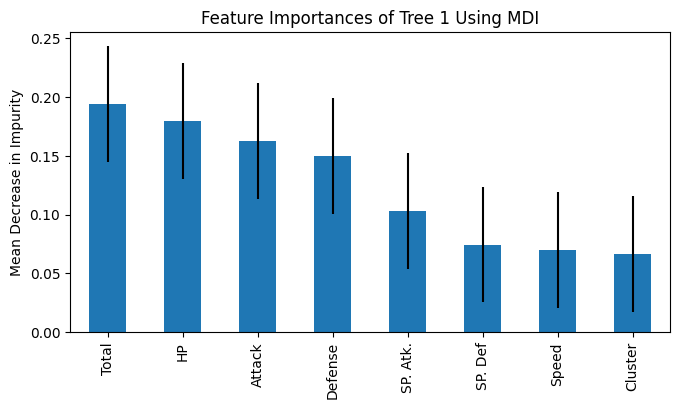

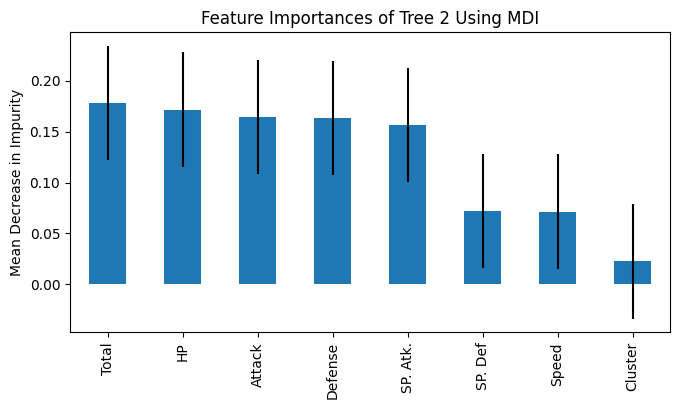

In [85]:
# Extract most important features
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

for i, tree in enumerate(dt_clusters_stats_model.best_estimator_.estimators_):
    std = np.std(tree.feature_importances_, axis=0)

    feature_names = X_clusters_stats_train.columns.tolist()
    feature_importances = pd.Series(sorted(tree.feature_importances_, reverse=True), index=feature_names)

    fig = plt.figure(figsize=(6, 3))
    axes = fig.add_axes(rect=(0, 0, 1, 1))

    feature_importances.plot.bar(yerr=std, ax=axes)
    axes.set_title(f"Feature Importances of Tree {i+1} Using MDI")
    axes.set_ylabel("Mean Decrease in Impurity")

    plt.show()

### Decision Tree with Color Clusters and Colors

In [86]:
# Create the DT model for clusters and colors
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputClassifier

# hyperparameters to try
dt_clusters_colors_hyperparameters = [
    {
        "estimator__criterion": ("gini", "entropy", "log_loss"),
        "estimator__max_depth": (10, 15, 20, None, ),
        "estimator__min_samples_split": (2, 6, 10, ),
        "estimator__min_samples_leaf":  range(1, 11),
        "estimator__random_state": (RNG_SEED, ),
    },
]

dt_clusters_colors_search = GridSearchCV(
    estimator=MultiOutputClassifier(DecisionTreeClassifier()),
    param_grid=dt_clusters_colors_hyperparameters,
    cv = 5
)
dt_clusters_colors_model = dt_clusters_colors_search.fit(X_clusters_colors_train, y_clusters_colors_train)

print(dt_clusters_colors_model.best_params_)

{'estimator__criterion': 'gini', 'estimator__max_depth': 10, 'estimator__min_samples_leaf': 10, 'estimator__min_samples_split': 2, 'estimator__random_state': 151}


In [87]:
dt_clusters_colors_pred = pd.DataFrame(dt_clusters_colors_model.predict(X_clusters_colors_test), columns=["Type 1 Pred", "Type 2 Pred"])

acc_either = either_accuracy_score(dt_clusters_colors_pred, y_clusters_colors_test)
acc_both = both_accuracy_score(dt_clusters_colors_pred, y_clusters_colors_test)

print(f"Either type accuracy: {acc_either}")
print(f"Both type accuracy: {acc_both}")

Either type accuracy: 0.22916666666666666
Both type accuracy: 0.010416666666666666


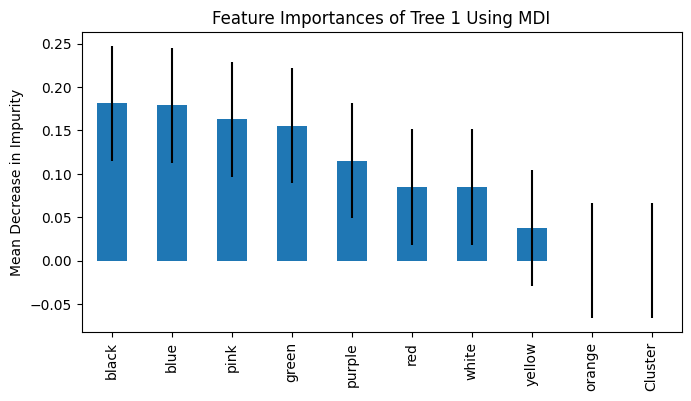

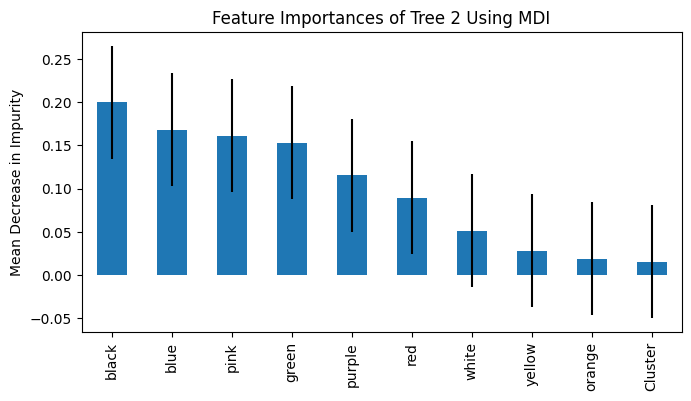

In [88]:
# Extract most important features
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

for i, tree in enumerate(dt_clusters_colors_model.best_estimator_.estimators_):
    std = np.std(tree.feature_importances_, axis=0)

    feature_names = X_clusters_colors_train.columns.tolist()
    feature_importances = pd.Series(sorted(tree.feature_importances_, reverse=True), index=feature_names)

    fig = plt.figure(figsize=(6, 3))
    axes = fig.add_axes(rect=(0, 0, 1, 1))

    feature_importances.plot.bar(yerr=std, ax=axes)
    axes.set_title(f"Feature Importances of Tree {i+1} Using MDI")
    axes.set_ylabel("Mean Decrease in Impurity")

    plt.show()

### Decision Tree with In-Game Statistics and Colors

In [89]:
# Create the DT model for stats and colors
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputClassifier

# hyperparameters to try
dt_stats_colors_hyperparameters = [
    {
        "estimator__criterion": ("gini", "entropy", "log_loss"),
        "estimator__max_depth": (10, 15, 20, None, ),
        "estimator__min_samples_split": (2, 6, 10, ),
        "estimator__min_samples_leaf":  range(1, 11),
        "estimator__random_state": (RNG_SEED, ),
    },
]

dt_stats_colors_search = GridSearchCV(
    estimator=MultiOutputClassifier(DecisionTreeClassifier()),
    param_grid=dt_stats_colors_hyperparameters,
    cv = 5
)
dt_stats_colors_model = dt_stats_colors_search.fit(X_stats_colors_train, y_stats_colors_train)

print(dt_stats_colors_model.best_params_)

{'estimator__criterion': 'gini', 'estimator__max_depth': 15, 'estimator__min_samples_leaf': 10, 'estimator__min_samples_split': 2, 'estimator__random_state': 151}


In [90]:
dt_stats_colors_pred = pd.DataFrame(dt_stats_colors_model.predict(X_stats_colors_test), columns=["Type 1 Pred", "Type 2 Pred"])

acc_either = either_accuracy_score(dt_stats_colors_pred, y_stats_colors_test)
acc_both = both_accuracy_score(dt_stats_colors_pred, y_stats_colors_test)

print(f"Either type accuracy: {acc_either}")
print(f"Both type accuracy: {acc_both}")

Either type accuracy: 0.28125
Both type accuracy: 0.005208333333333333


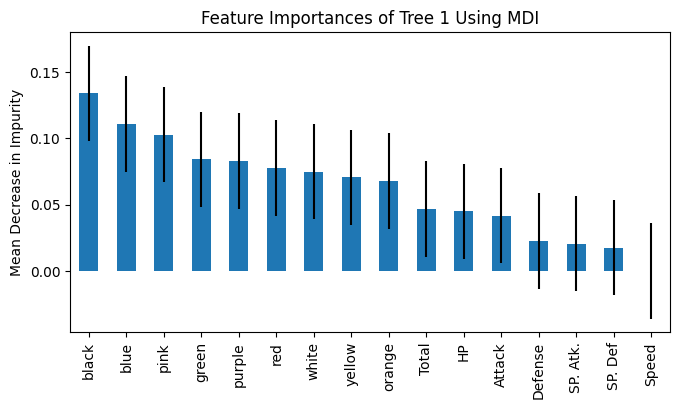

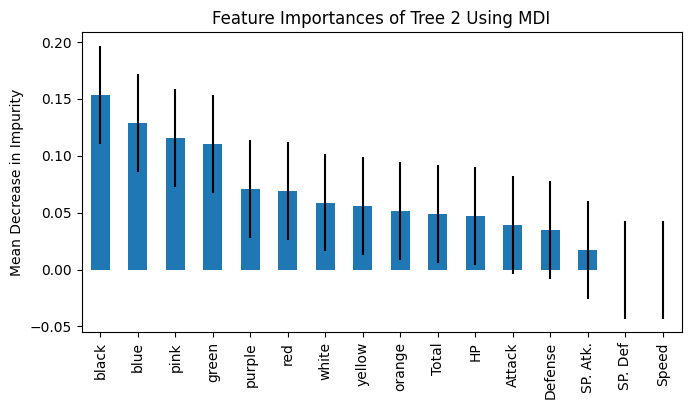

In [91]:
# Extract most important features
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

for i, tree in enumerate(dt_stats_colors_model.best_estimator_.estimators_):
    std = np.std(tree.feature_importances_, axis=0)

    feature_names = X_stats_colors_train.columns.tolist()
    feature_importances = pd.Series(sorted(tree.feature_importances_, reverse=True), index=feature_names)

    fig = plt.figure(figsize=(6, 3))
    axes = fig.add_axes(rect=(0, 0, 1, 1))

    feature_importances.plot.bar(yerr=std, ax=axes)
    axes.set_title(f"Feature Importances of Tree {i+1} Using MDI")
    axes.set_ylabel("Mean Decrease in Impurity")

    plt.show()